In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Restrict permissions

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
!unzip microsoft-catsvsdogs-dataset.zip -d cats_vs_dogs

Streaming output truncated to the last 5000 lines.
  inflating: cats_vs_dogs/PetImages/Dog/550.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5500.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5501.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5502.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5503.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5504.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5505.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5506.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5507.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5508.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5509.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/551.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5510.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5511.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5512.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5513.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5514.jpg  
  inflating: cats_vs_dogs/PetImages/Dog/5515.jpg  
  inflating: cats_vs_dogs/PetImag

In [4]:
import cv2
import os

for folder in ["Cat", "Dog"]:
    for file in os.listdir(f"/content/cats_vs_dogs/PetImages/{folder}"):
        try:
            img = cv2.imread(f"/content/cats_vs_dogs/PetImages/{folder}/{file}")
            if img is None:
                os.remove(f"/content/cats_vs_dogs/PetImages/{folder}/{file}")
        except:
            print(f"Removed corrupted file: {file}")

In [5]:
print("Cat images:", len(os.listdir("/content/cats_vs_dogs/PetImages/Cat")))
print("Dog images:", len(os.listdir("/content/cats_vs_dogs/PetImages/Dog")))

Cat images: 12498
Dog images: 12499


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=40,       # Random rotations (0-40 degrees)
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Strategy for filling in new pixels
)

# Point the generator to your directory
train_generator = train_datagen.flow_from_directory(
    directory='cats_vs_dogs/PetImages',  # Parent directory containing Cat/Dog folders
    target_size=(150, 150),              # Resizes all images to 150x150
    batch_size=32,
    class_mode='binary',                 # Binary classification (cat vs dog)
    classes=['Cat', 'Dog'],              # Explicitly specify class folders
    shuffle=True                         # Shuffle the data for better training
)

# Verify it's working
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes.")
print(f"Class labels: {train_generator.class_indices}")  # Should show {'Cat': 0, 'Dog': 1}

Found 24997 images belonging to 2 classes.
Found 24997 images belonging to 2 classes.
Class labels: {'Cat': 0, 'Dog': 1}


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First Conv Block
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third Conv Block
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Fourth Conv Block
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Classifier Head
    Flatten(),
    Dropout(0.5),  # Reduces overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output (cat=0, dog=1)
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Full dataset per epoch
    epochs=30,  # Adjust based on performance
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
562/781 ━━━━━━━━━━━━━━━━━━━━ 46s 210ms/step - accuracy: 0.5242 - loss: 0.6968

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 174s 213ms/step - accuracy: 0.5310 - loss: 0.6937
Epoch 2/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.6875 - loss: 0.6702   
Epoch 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/781 ━━━━━━━━━━━━━━━━━━━━ 2:11 206ms/step - accuracy: 0.6045 - loss: 0.6577

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 164s 210ms/step - accuracy: 0.6263 - loss: 0.6465
Epoch 4/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.7188 - loss: 0.5551   
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


160/781 ━━━━━━━━━━━━━━━━━━━━ 2:11 211ms/step - accuracy: 0.6826 - loss: 0.5952

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 203s 211ms/step - accuracy: 0.6862 - loss: 0.5962
Epoch 6/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.6562 - loss: 0.5949   
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


129/781 ━━━━━━━━━━━━━━━━━━━━ 2:15 207ms/step - accuracy: 0.6946 - loss: 0.5823

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 201s 210ms/step - accuracy: 0.7024 - loss: 0.5712
Epoch 8/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.7188 - loss: 0.5339   
Epoch 9/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


607/781 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - accuracy: 0.7284 - loss: 0.5369

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 164s 210ms/step - accuracy: 0.7308 - loss: 0.5343
Epoch 10/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.7188 - loss: 0.4970   
Epoch 11/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


661/781 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - accuracy: 0.7529 - loss: 0.5054

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 203s 212ms/step - accuracy: 0.7535 - loss: 0.5043
Epoch 12/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.8750 - loss: 0.3757   
Epoch 13/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


597/781 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.7785 - loss: 0.4652

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 163s 209ms/step - accuracy: 0.7798 - loss: 0.4637
Epoch 14/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.7812 - loss: 0.5091   
Epoch 15/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/781 ━━━━━━━━━━━━━━━━━━━━ 2:18 210ms/step - accuracy: 0.7813 - loss: 0.4663

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 201s 208ms/step - accuracy: 0.7941 - loss: 0.4435
Epoch 16/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.9688 - loss: 0.2193   
Epoch 17/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


215/781 ━━━━━━━━━━━━━━━━━━━━ 1:58 209ms/step - accuracy: 0.7952 - loss: 0.4318

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 162s 207ms/step - accuracy: 0.8073 - loss: 0.4157
Epoch 18/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.8438 - loss: 0.3463   
Epoch 19/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


590/781 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.8237 - loss: 0.3903

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 163s 208ms/step - accuracy: 0.8243 - loss: 0.3895
Epoch 20/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.8438 - loss: 0.3747   
Epoch 21/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


421/781 ━━━━━━━━━━━━━━━━━━━━ 1:14 208ms/step - accuracy: 0.8315 - loss: 0.3768

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 162s 207ms/step - accuracy: 0.8323 - loss: 0.3740
Epoch 22/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.8125 - loss: 0.3279   
Epoch 23/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


633/781 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.8486 - loss: 0.3440

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 162s 207ms/step - accuracy: 0.8482 - loss: 0.3445
Epoch 24/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.8125 - loss: 0.4266   
Epoch 25/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


454/781 ━━━━━━━━━━━━━━━━━━━━ 1:07 205ms/step - accuracy: 0.8529 - loss: 0.3362

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 201s 206ms/step - accuracy: 0.8521 - loss: 0.3373
Epoch 26/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.7812 - loss: 0.4651   
Epoch 27/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


251/781 ━━━━━━━━━━━━━━━━━━━━ 1:50 209ms/step - accuracy: 0.8513 - loss: 0.3357

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 204s 208ms/step - accuracy: 0.8525 - loss: 0.3320
Epoch 28/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.9062 - loss: 0.2574   
Epoch 29/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


262/781 ━━━━━━━━━━━━━━━━━━━━ 1:47 207ms/step - accuracy: 0.8566 - loss: 0.3209

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


781/781 ━━━━━━━━━━━━━━━━━━━━ 162s 208ms/step - accuracy: 0.8575 - loss: 0.3209
Epoch 30/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.9062 - loss: 0.2050   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


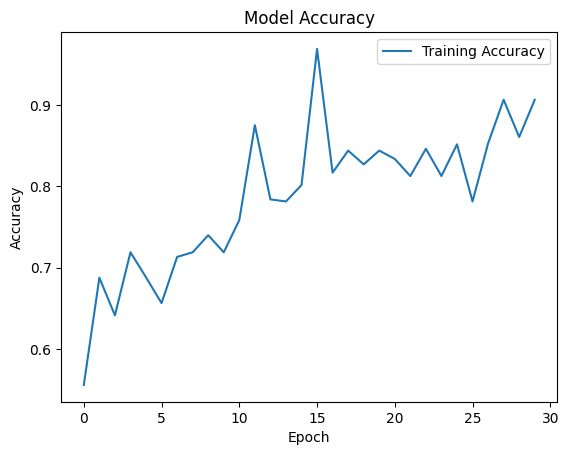

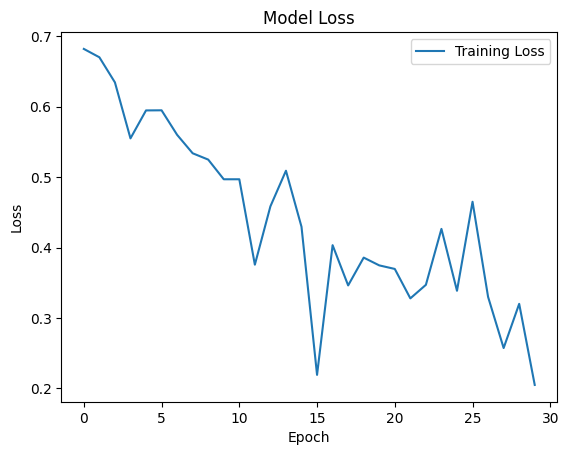

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

test_generator = test_datagen.flow_from_directory(
    'cats_vs_dogs/PetImages',  # Replace with your test directory path
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for correct label alignment
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Found 24997 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/782 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8784 - loss: 0.2740

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.8795 - loss: 0.2721
Test Accuracy: 90.36%


In [11]:
model.save('cat_dog_cnn.h5')  # Save as HDF5 file

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0  # Normalize

    pred = model.predict(x)
    if pred[0] > 0.5:
        return "Dog (Probability: {:.2f}%)".format(pred[0][0]*100)
    else:
        return "Cat (Probability: {:.2f}%)".format((1-pred[0][0])*100)

# Example usage
print(predict_image('/content/dog.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
Dog (Probability: 100.00%)


In [15]:
# Write the Streamlit app to a file
with open('app.py', 'w') as f:
    f.write('''
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load model (upload your .h5 file to Colab first)
model = tf.keras.models.load_model('cat_dog_cnn.h5')

def predict_image(uploaded_file):
    img = Image.open(uploaded_file).resize((150, 150))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)[0][0]
    return "Dog 🐶" if pred > 0.5 else "Cat 🐱"

st.title("Cat vs. Dog Classifier")
uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "png"])
if uploaded_file:
    st.image(uploaded_file, use_column_width=True)
    st.write("Prediction:", predict_image(uploaded_file))
''')